<a href="https://colab.research.google.com/github/TheKnight909/T5/blob/main/Week9_RAG_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Violation RAG System
In this exam, you will implement a Retrieval-Augmented Generation (RAG) system that uses a language model and a vector database to answer questions about traffic violations. The goal is to generate answers with relevant data based on a dataset of traffic violations and fines.

Here are helpful resources:
* [LangChain](https://www.langchain.com/)
* [groq cloud documentation](https://console.groq.com/docs/models)
* [LangChain HuggingFace](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers/)
* [Chroma Vector Store](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
* [Chroma Website](https://docs.trychroma.com/getting-started)
* [ChatGroq LangChain](https://python.langchain.com/docs/integrations/chat/groq/)
* [LLM Chain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html#langchain.chains.llm.LLMChain)

Dataset [source](https://www.moi.gov.sa/wps/portal/Home/sectors/publicsecurity/traffic/contents/!ut/p/z0/04_Sj9CPykssy0xPLMnMz0vMAfIjo8ziDTxNTDwMTYy83V0CTQ0cA71d_T1djI0MXA30gxOL9L30o_ArApqSmVVYGOWoH5Wcn1eSWlGiH1FSlJiWlpmsagBlKCQWqRrkJmbmqRqUZebngB2gUJAKdERJZmqxfkG2ezgAhzhSyw!!/)

Some installs if needed:
```python
!pip install langchain_huggingface langchain langchain-community langchain_chroma Chroma langchain_groq LLMChain
```

In [102]:
!pip install langchain_huggingface langchain langchain-community langchain_chroma Chroma langchain_groq LLMChain

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement LLMChain (from versions: none)
ERROR: No matching distribution found for LLMChain


In [2]:
!kaggle datasets download -d khaledzsa/dataset
!unzip dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/dataset
License(s): unknown
  0% 0.00/3.73k [00:00<?, ?B/s]
100% 3.73k/3.73k [00:00<00:00, 7.85MB/s]
Archive:  dataset.zip
  inflating: Dataset.csv             


## Step 1: Install Required Libraries

To begin, install the necessary libraries for this project. The libraries include `LangChain` for building language model chains, and `Chroma` for managing a vector database.

In [3]:
import os
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
import markdown
from langchain.text_splitter import RecursiveCharacterTextSplitter

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## Step 2: Load the Traffic Violations Dataset

In [4]:
df = pd.read_csv('/content/Dataset.csv')
df

,المخالفة,الغرامة
0,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 100 - 150 ريال
1,ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها.,الغرامة المالية 100 - 150 ريال
2,عدم وجود تأمين ساري للمركبة.,الغرامة المالية 100 - 150 ريال
3,عبور المشاة للطرق من غير الأماكن المخصصة لهم.,الغرامة المالية 100 - 150 ريال
4,عدم تقيد المشاة بالإشارات الخاصة بهم.,الغرامة المالية 100 - 150 ريال
...,...,...
99,القيام بأعمال الطرق قبل التنسيق مع الإدارة الم...,الغرامة المالية 5000 - 10000 ريال
100,سماح أصحاب الحيوانات بعبور حيواناتهم من غير ال...,الغرامة المالية 5000 - 10000 ريال
101,استخدام لوحات غير عائدة للمركبة.,الغرامة المالية 5000 - 10000 ريال
102,طمس رقم هيكل المركبة أو محاولة طمسه.,الغرامة المالية 5000 - 10000 ريال


You are provided with a dataset of traffic violations. Load the CSV file into a pandas DataFrame and preview the first few rows of the dataset using `.head()`. You can also try and see the dataset's characteristics.

### EDA

In [8]:
df.shape

(104, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   المخالفة  104 non-null    object
 1   الغرامة   104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [10]:
df.columns

Index(['المخالفة', 'الغرامة'], dtype='object')

In [11]:
df.describe()

,المخالفة,الغرامة
count,104,104
unique,104,7
top,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 500 - 900 ريال
freq,1,25


In [12]:
df['الغرامة'].value_counts()

,count
الغرامة,
الغرامة المالية 500 - 900 ريال,25
الغرامة المالية 1000 - 2000 ريال,25
الغرامة المالية 150 - 300 ريال,15
الغرامة المالية 3000 - 6000 ريال,14
الغرامة المالية 300 - 500 ريال,12
الغرامة المالية 100 - 150 ريال,7
الغرامة المالية 5000 - 10000 ريال,6


<Axes: xlabel='الغرامة'>

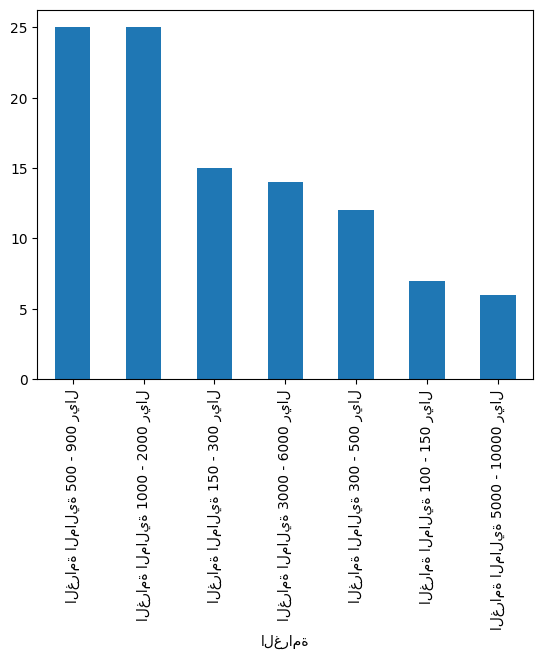

In [13]:
df['الغرامة'].value_counts().plot(kind='bar')

In [14]:
df['المخالفة'][0]

'قيادة المركبة في الأسواق التي لا يسمح بالقيادة فيها.'

In [15]:
df['المخالفة'].unique()

array(['قيادة المركبة في الأسواق التي لا يسمح بالقيادة فيها.',
       'ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها.',
       'عدم وجود تأمين ساري للمركبة.',
       'عبور المشاة للطرق من غير الأماكن المخصصة لهم.',
       'عدم تقيد المشاة بالإشارات الخاصة بهم.',
       'وقوف المركبة في أماكن غير مخصصة للوقوف.',
       'عدم إعطاء أفضلية المرور للمشاة أثناء عبورهم في المسارات المخصصة لهم.',
       'عدم استخدام إشارة الالتفاف عند التحول لليمين أو اليسار أو التجاوز أو تغيير المسار.',
       'الرجوع إلى الخلف في الطريق العام لمسافة تزيد على عشرين متراً.',
       'قيام سائق الدراجة الآلية أو العادية - أو ما في حكمهما - بالتعلق بأي مركبة أخرى، أو سحب أو حمل أشياء تعرض مستخدمي الطريق للخطر.',
       'مخالفة قواعد استعمال أنوار التلاقي.',
       'عدم حمل رخصة القيادة أو رخصة السير أثناء القيادة.',
       'إساءة استعمال منبه المركبة.',
       'عدم تقديم المركبة للفحص الفني الدوري.',
       'مخالفة تنظيمات السير على الطرق.', 'عدم ربط حزام الأمان.',
       'وضع حواجز داخل المركبة أو خارجها تعوق 

## Step 3: Create Markdown Content from the Dataset

For each traffic violation in the dataset, you will generate markdown text that describes the violation and the associated fine. Create a loop to iterate through the dataset and store the generated markdown in a list. Each fine should look like this:

**المخالفة** - الغرامة

In [36]:
markdown_list = []

for index, row in df.iterrows():
    violation = row['المخالفة']
    fine = row['الغرامة']
    markdown_list.append(f"{violation} - {fine}")

# Print first few markdown entries to verify
markdown_list

['قيادة المركبة في الأسواق التي لا يسمح بالقيادة فيها. - الغرامة المالية 100 - 150 ريال',
 'ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها. - الغرامة المالية 100 - 150 ريال',
 'عدم وجود تأمين ساري للمركبة. - الغرامة المالية 100 - 150 ريال',
 'عبور المشاة للطرق من غير الأماكن المخصصة لهم. - الغرامة المالية 100 - 150 ريال',
 'عدم تقيد المشاة بالإشارات الخاصة بهم. - الغرامة المالية 100 - 150 ريال',
 'وقوف المركبة في أماكن غير مخصصة للوقوف. - الغرامة المالية 100 - 150 ريال',
 'عدم إعطاء أفضلية المرور للمشاة أثناء عبورهم في المسارات المخصصة لهم. - الغرامة المالية 100 - 150 ريال',
 'عدم استخدام إشارة الالتفاف عند التحول لليمين أو اليسار أو التجاوز أو تغيير المسار. - الغرامة المالية 150 - 300 ريال',
 'الرجوع إلى الخلف في الطريق العام لمسافة تزيد على عشرين متراً. - الغرامة المالية 150 - 300 ريال',
 'قيام سائق الدراجة الآلية أو العادية - أو ما في حكمهما - بالتعلق بأي مركبة أخرى، أو سحب أو حمل أشياء تعرض مستخدمي الطريق للخطر. - الغرامة المالية 150 - 300 ريال',
 'مخالفة قواعد استعمال أنوار التلا

In [6]:
len(markdown_list)

104

## Step 4: Chunk the Markdown Data

Using LangChain's `RecursiveCharacterTextSplitter`, split the markdown texts into smaller chunks that will be stored in the vector database.

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=0)

documents = text_splitter.create_documents(markdown_list)

documents

[Document(metadata={}, page_content='قيادة المركبة في الأسواق التي لا يسمح بالقيادة فيها. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='عدم وجود تأمين ساري للمركبة. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='عبور المشاة للطرق من غير الأماكن المخصصة لهم. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='عدم تقيد المشاة بالإشارات الخاصة بهم. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='وقوف المركبة في أماكن غير مخصصة للوقوف. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='عدم إعطاء أفضلية المرور للمشاة أثناء عبورهم في المسارات المخصصة لهم. - الغرامة المالية 100 - 150 ريال'),
 Document(metadata={}, page_content='عدم استخدام إشارة الالتفاف عند التحول لليمين أو اليسار أو التجاوز أو تغيير المسار. - الغرامة المالية 150 - 300 ريال'),
 Document

## Step 5: Generate Embeddings for the Documents

Generate embeddings for the chunks of text using HuggingFace's pre-trained Arabic language model. These embeddings will be stored in a `Chroma` vector store.

In [8]:
embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/stsb-xlm-r-multilingual")
db = Chroma.from_documents(documents, embedding_model, persist_directory="./chroma_db")

<ipython-input-8-af7a7f0c5969>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/stsb-xlm-r-multilingual")
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in you

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
import os
import json
from langchain_chroma import Chroma
from langchain.chains import RetrievalQA
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
def query_chroma_db(query, db):
    docs = db.similarity_search(query)
    results = [doc.page_content for doc in docs]
    return results

In [13]:
query_chroma_db("عدم الوقوف تماماً عند إشارة قف", db)

['عدم الوقوف تماماً عند إشارة قف. - الغرامة المالية 500 - 900 ريال',
 'عدم الوقوف عند مراكز الضبط الأمني أو نقاط التفتيش أو عدم الوقوف للدورية الأمنية عند وجود توجيه أو علامة توجب الوقوف. - الغرامة المالية 3000 - 6000 ريال',
 'عدم تقيد المشاة بالإشارات الخاصة بهم. - الغرامة المالية 100 - 150 ريال',
 'عدم استخدام إشارة الالتفاف عند التحول لليمين أو اليسار أو التجاوز أو تغيير المسار. - الغرامة المالية 150 - 300 ريال']

## Step 6: Define the RAG Prompt Template

In [86]:
PROMPT_TEMPLATE="""
مرحباً! أنا مساعد رقمي متخصص في المعلومات المتعلقة بالمخالفات المرورية.
الاجابات جميع بالعربية
يجب ان يكون جميع الاسئلة متعلقة بالمخالفات
أي سؤال باي لغة اخرى يرجى الجواب بي أكتب بالعربي يا حبي

ملاحظة: المعلومات المقدمة قد تكون غير دقيقة. يرجى زيارة موقع مبادرة المرور للتحقق من المعلومات الصحيحة.

السؤال: {سؤال}

المعلومات ذات الصلة: {محتوى}

الإجابة:
    """

prompt_template = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["محتوى", "سؤال"]
)

Define a custom prompt template in Arabic to retrieve traffic violation-related answers based on the context. Ensure the template greets the user first, states that the information provided could be incorrect, and advises the user to visit the traffic initiative website to verify. Additionally, provide the user with advice in Arabic, ensuring it stays within the given context.

## Step 7: Initialize the Language Model

Initialize the language model using the Groq API. Set up the model with a specific configuration, including the API key, temperature setting, and model name.

In [87]:
groq_api_key = ""
llm = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name= "llama3-8b-8192")

## Step 8: Create the LLM Chain

Now, you will create an LLM Chain that combines the language model and the prompt template you defined. This chain will be used to generate responses based on the retrieved context.

In [88]:
MODEL = LLMChain(llm=llm,
                 prompt=prompt_template,
                 verbose=True)

## Step 9: Implement the Query Function

Create a function `query_rag` that will take a user query as input, retrieve relevant context from the vector store, and use the language model to generate a response based on that context.

In [89]:
def query_rag(query: str):
    similarity_search_results = db.similarity_search_with_score(query)
    context_text = "\n\n".join([doc.page_content for doc, _score in similarity_search_results])
    rag_response = MODEL.invoke({"محتوى": context_text, "سؤال": query})

    return rag_response

## Step 10: Inference - Running Queries in the RAG System

In this final step, you will implement an inference pipeline to handle real-time queries. You will allow the system to retrieve the most relevant violations and fines based on a user's input and generate a response.

1. Inference Workflow:

  * The user inputs a query (e.g., "ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟").
  * The system searches for the most relevant context from the traffic violation vector store.
  * It generates an answer and advice based on the context.

2. Goal:
  * Run the inference to answer questions based on the traffic violation dataset.

In [92]:
response = query_rag("كم سعر البيتزا")
response

Prompt after formatting:

مرحباً! أنا مساعد رقمي متخصص في المعلومات المتعلقة بالمخالفات المرورية.
الاجابات جميع بالعربية 
يجب ان يكون جميع الاسئلة متعلقة بالمخالفات
أي سؤال باي لغة اخرى يرجى الجواب بي أكتب بالعربي يا حبي

ملاحظة: المعلومات المقدمة قد تكون غير دقيقة. يرجى زيارة موقع مبادرة المرور للتحقق من المعلومات الصحيحة.

السؤال: كم سعر البيتزا

المعلومات ذات الصلة: طمس رقم هيكل المركبة أو محاولة طمسه. - الغرامة المالية 5000 - 10000 ريال

رمي أجسام خارج المركبة. - الغرامة المالية 300 - 500 ريال

الانشغال بغير الطريق أثناء قيادة المركبة. - الغرامة المالية 300 - 500 ريال

عبور المشاة للطرق السريعة. - الغرامة المالية 1000 - 2000 ريال

الإجابة:
    

> Finished chain.


{'محتوى': 'طمس رقم هيكل المركبة أو محاولة طمسه. - الغرامة المالية 5000 - 10000 ريال\n\nرمي أجسام خارج المركبة. - الغرامة المالية 300 - 500 ريال\n\nالانشغال بغير الطريق أثناء قيادة المركبة. - الغرامة المالية 300 - 500 ريال\n\nعبور المشاة للطرق السريعة. - الغرامة المالية 1000 - 2000 ريال',
 'سؤال': 'كم سعر البيتزا',
 'text': 'أهلاً! للاسف، السؤال لا يرتبط بالمخالفات المرورية، فالسؤال عن سعر البيتزا لا يهم في مجال المخالفات المرورية. السؤال يجب أن يكون متعلقاً بالمخالفات المرورية فقط.\n\nلذلك، لا أستطيع الإجابة على هذا السؤال. إذا كنت تريد سؤال آخر متعلق بالمخالفات المرورية، فأنا سأجيب بكفاءة.'}

In [93]:
print(f'Context:\n{response["محتوى"]}\n\nQuestion:\n{response["سؤال"]}\n\nText: \n{response["text"]}')

Context:
طمس رقم هيكل المركبة أو محاولة طمسه. - الغرامة المالية 5000 - 10000 ريال

رمي أجسام خارج المركبة. - الغرامة المالية 300 - 500 ريال

الانشغال بغير الطريق أثناء قيادة المركبة. - الغرامة المالية 300 - 500 ريال

عبور المشاة للطرق السريعة. - الغرامة المالية 1000 - 2000 ريال

Question:
كم سعر البيتزا

Text: 
أهلاً! للاسف، السؤال لا يرتبط بالمخالفات المرورية، فالسؤال عن سعر البيتزا لا يهم في مجال المخالفات المرورية. السؤال يجب أن يكون متعلقاً بالمخالفات المرورية فقط.

لذلك، لا أستطيع الإجابة على هذا السؤال. إذا كنت تريد سؤال آخر متعلق بالمخالفات المرورية، فأنا سأجيب بكفاءة.


In [96]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 13.0.1
    Uninstalling websockets-13.0.1:
      Successfully uninstalled websockets-13.0.1
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2


In [97]:
import gradio as gr

In [101]:
def query_rag_interface(question):
    response = query_rag(question)
    temp=f'Context:\n{response["محتوى"]}\n\nQuestion:\n{response["سؤال"]}\n\nText: \n{response["text"]}'
    return temp

iface = gr.Interface(
    fn=query_rag_interface,
    inputs=gr.Textbox(lines=2, placeholder="اسألني سؤال له علاقة بأنظمة المرور في السعودية..."),
    outputs=gr.Textbox(),
    title="دليل المخالفات المرورية ",
    description="اسألني أي سؤال عن الغرامات او الاستفسارات حول أنظمة المرور في المملكة العربية السعودية",
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e05c423383130fa798.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
